In [33]:
# ---------- 4. ROBUSTNESS ANALYSIS (WITH PLOTS) ----------
from ema_workbench import load_results
import matplotlib.pyplot as plt
import seaborn as sns
#from ema_workbench.analysis import RobustnessEvaluator
#from ema_workbench.em_framework.optimization import ScalarOutcome
import pandas as pd
import numpy as np
from ema_workbench import Policy
from ema_workbench import Scenario


# --- Load results
experiments, outcomes = load_results("results/promising_resample_1000.tar.gz")
policies = experiments["policy"].unique()
outcome_names = list(outcomes.keys())


Regret analysis

In [72]:
# setup a dataframe for the outcomes
# we add scenario and policy as additional columns
# we need scenario because regret is calculated on a scenario by scenario basis
# we add policy because we need to get the maximum regret for each policy.
outcomes = pd.DataFrame(outcomes)
outcomes['scenario'] = experiments.scenario
outcomes['policy'] = experiments.policy


def calculate_regret(x):
    # policy is non numeric, so max is not defined for this
    best = x.min(numeric_only=True)
    
    # max_P is minimized so best performance is minimum.
    #best['max_P'] = x.max_P.min()    
    
    # again we need to handle max_P a bit different
    regret = best + x.loc[:, best.index]
    #regret['max_P'] = x.max_P - best.max_P

    # we add policy back into our regret dataframe
    # so we know the regret for each policy
    regret['policy'] = x.policy
    return regret

# we want to calculate regret on a scenario by scenario basis
regret = outcomes.groupby('scenario', group_keys=False).apply(calculate_regret)

# as last step, we calculate the maximum and mean regret for each policy
max_regret = regret.groupby('policy').max()
mean_regret= regret.groupby('policy').mean()

C:\Users\tlwal\AppData\Local\Temp\ipykernel_27076\3384325222.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  regret = outcomes.groupby('scenario', group_keys=False).apply(calculate_regret)
C:\Users\tlwal\AppData\Local\Temp\ipykernel_27076\3384325222.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  regret = outcomes.groupby('scenario', group_keys=False).apply(calculate_regret)
C:\Users\tlwal\AppData\Local\Temp\ipykernel_27076\3384325222.py:30: FutureWarning: The default of observed=False is deprecate

In [64]:
mean_regret.head()

,Gelderland Expected Annual Damage,Gelderland Dike Investment Costs,Gelderland Expected Number of Deaths,Overijssel Expected Annual Damage,Overijssel Dike Investment Costs,Overijssel Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
policy,,,,,,,,
pol_000,6.312155e+08,6.261160e+08,0.548356,1.225215e+07,3.035153e+07,0.007754,121200000.0,0.000000
pol_001,7.606397e+06,6.054299e+08,0.019446,1.361367e+06,3.880493e+07,0.000976,357700000.0,0.000000
pol_002,1.242761e+08,4.514227e+08,0.025400,1.588452e+07,3.667233e+07,0.001199,121200000.0,7331.159654
pol_003,9.253345e+07,4.882024e+08,0.182608,1.470251e+06,3.768361e+07,0.001049,121200000.0,0.000000
pol_004,3.376830e+08,4.833947e+08,0.117715,1.476709e+08,6.320800e+06,0.041244,61400000.0,7232.465516


In [73]:
# Normalize regret columns (min-max scaling)
for df in [mean_regret, max_regret]:
    for col in df.columns:
        mn, mx = df[col].min(), df[col].max()
        norm_col = col + "_norm"
        df[norm_col] = (df[col] - mn) / (mx - mn) if mx > mn else 0.0

# Overall scores, exclude Gelderland Expected Annual Damage and Gelderland Dike Investment Costs
mean_regret = mean_regret.drop(columns=["Gelderland Expected Annual Damage_norm", "Gelderland Dike Investment Costs_norm"])
max_regret = max_regret.drop(columns=["Gelderland Expected Annual Damage_norm", "Gelderland Dike Investment Costs_norm"])
# Normalize again for overall scores
mean_norm_cols = [col for col in mean_regret.columns if col.endswith("_norm")]
max_norm_cols = [col for col in max_regret.columns if col.endswith("_norm")]

mean_regret["overall_mean_regret"] = mean_regret[mean_norm_cols].mean(axis=1)
max_regret["overall_max_regret"] = max_regret[max_norm_cols].max(axis=1)
max_regret["overall_max_regret_mean"] = max_regret[max_norm_cols].mean(axis=1)


In [74]:
print(mean_regret.columns)

Index(['Gelderland Expected Annual Damage', 'Gelderland Dike Investment Costs',
       'Gelderland Expected Number of Deaths',
       'Overijssel Expected Annual Damage', 'Overijssel Dike Investment Costs',
       'Overijssel Expected Number of Deaths', 'RfR Total Costs',
       'Expected Evacuation Costs',
       'Gelderland Expected Number of Deaths_norm',
       'Overijssel Expected Annual Damage_norm',
       'Overijssel Dike Investment Costs_norm',
       'Overijssel Expected Number of Deaths_norm', 'RfR Total Costs_norm',
       'Expected Evacuation Costs_norm', 'overall_mean_regret'],
      dtype='object')


In [66]:
mean_regret.head()

,Gelderland Expected Number of Deaths,Overijssel Expected Annual Damage,Overijssel Dike Investment Costs,Overijssel Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Gelderland Expected Annual Damage_norm,Gelderland Dike Investment Costs_norm,Gelderland Expected Number of Deaths_norm,Overijssel Expected Annual Damage_norm,Overijssel Dike Investment Costs_norm,Overijssel Expected Number of Deaths_norm,RfR Total Costs_norm,Expected Evacuation Costs_norm,overall_mean_regret
policy,,,,,,,,,,,,,,,
pol_000,0.548356,1.225215e+07,3.035153e+07,0.007754,121200000.0,0.000000,0.959647,0.785838,0.997608,0.081053,0.346917,0.069600,0.092959,0.000000,0.416703
pol_001,0.019446,1.361367e+06,3.880493e+07,0.000976,357700000.0,0.000000,0.011564,0.710803,0.035378,0.009006,0.443539,0.008761,0.274352,0.000000,0.186675
pol_002,0.025400,1.588452e+07,3.667233e+07,0.001199,121200000.0,7331.159654,0.188939,0.152168,0.046210,0.105082,0.419163,0.010758,0.092959,0.649389,0.208084
pol_003,0.182608,1.470251e+06,3.768361e+07,0.001049,121200000.0,0.000000,0.140680,0.285580,0.332213,0.009726,0.430722,0.009415,0.092959,0.000000,0.162662
pol_004,0.117715,1.476709e+08,6.320800e+06,0.041244,61400000.0,7232.465516,0.513385,0.268141,0.214155,0.976902,0.072247,0.370191,0.047093,0.640647,0.387845


In [43]:
# Sort for convenience
#df_mean_regret = mean_regret.sort_values("overall_mean_regret").reset_index(drop=True)
#df_max_regret = max_regret.sort_values("overall_max_regret").reset_index(drop=True)

# Show top rows
#print("Top policies by MEAN regret:")
#display(df_mean_regret.head())

#print("Top policies by MAX regret:")
#display(df_max_regret.head())

# Save if needed
#df_mean_regret.to_csv("results/mean_regret_scores.csv", index=False)
#df_max_regret.to_csv("results/max_regret_scores.csv", index=False)

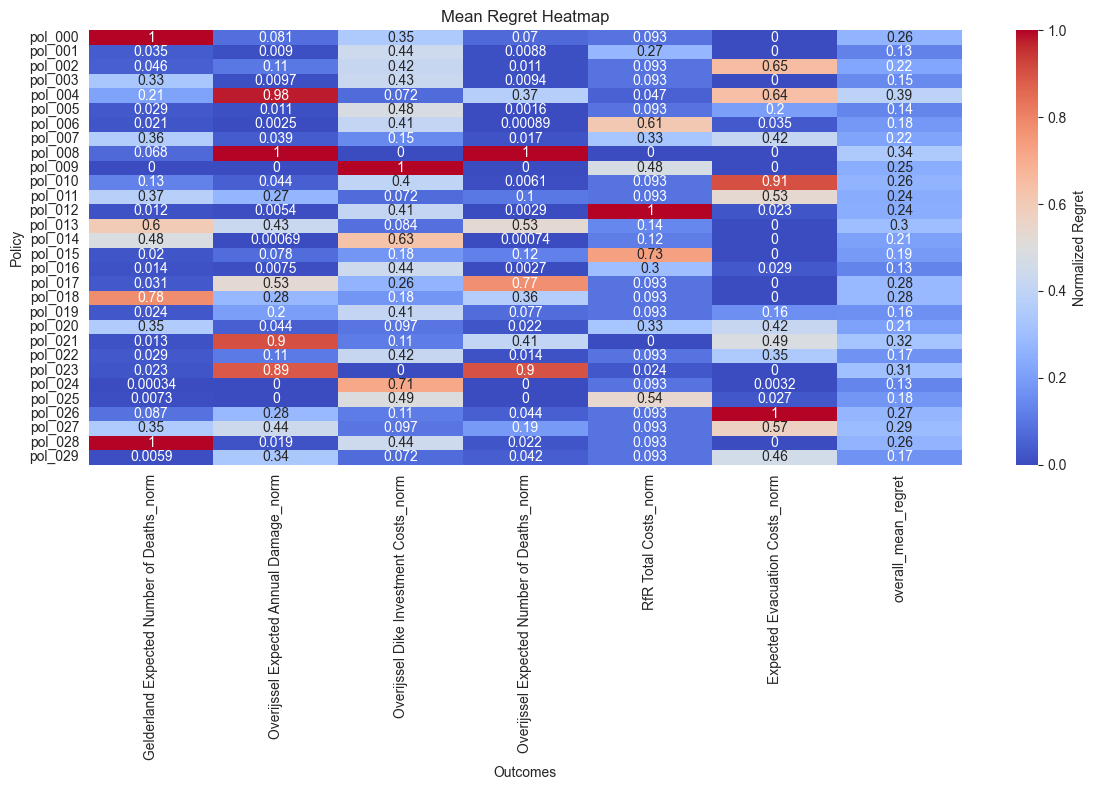

In [75]:
#For both mean and max regret, create a heatmap of the first 20 polices from the sorted dataframe
plt.figure(figsize=(12, 8)) 
#sns.heatmap(df_mean_regret.head(20)[mean_norm_cols], annot=True, cmap='coolwarm', cbar_kws={'label': 'Normalized Regret'})
#plt.title("Mean Regret Heatmap (Top 20 Policies)")

# Add "overall_mean_regret" to the columns to plot
cols_to_plot = mean_norm_cols + ["overall_mean_regret"]

# Plot heatmap 
sns.heatmap(mean_regret[cols_to_plot], annot=True, cmap='coolwarm', cbar_kws={'label': 'Normalized Regret'})
plt.title("Mean Regret Heatmap")

plt.xlabel("Outcomes")
plt.ylabel("Policy")
#plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



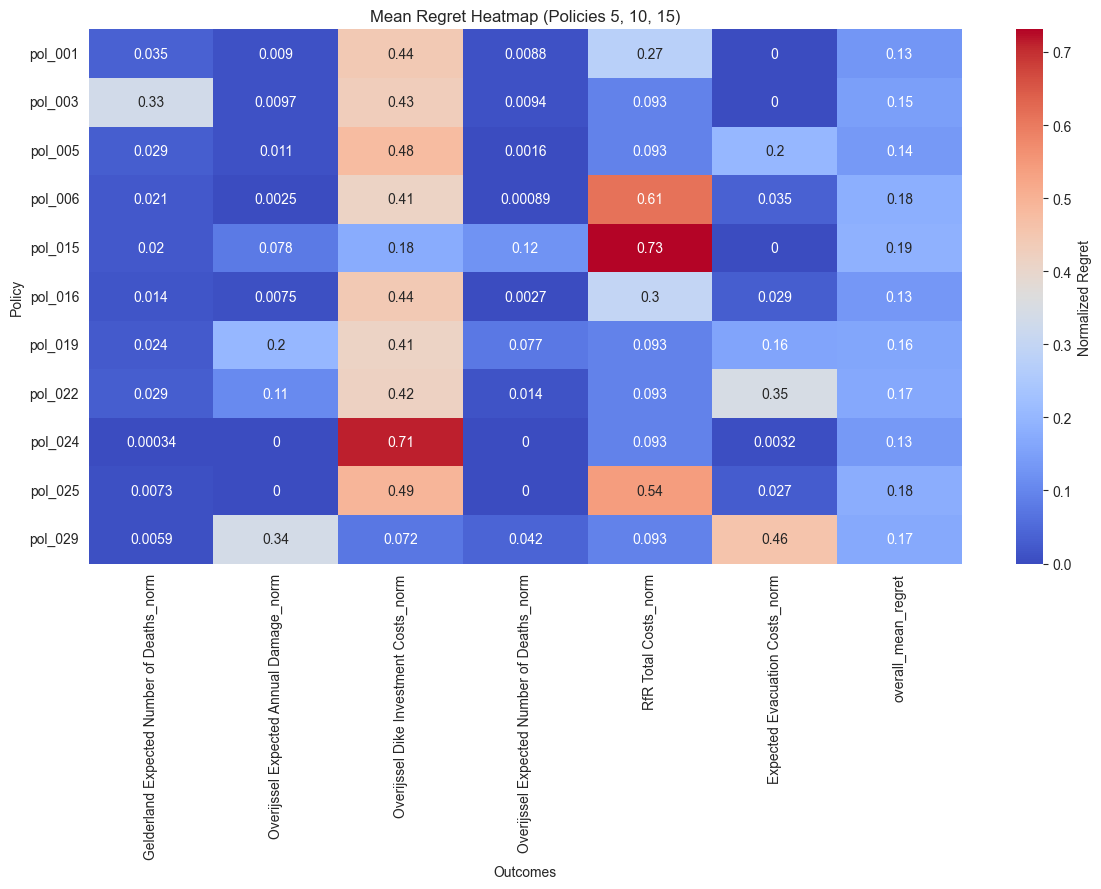

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select specific rows by index
cols_to_plot = mean_norm_cols + ["overall_mean_regret"]

selected_rows = mean_regret.iloc[[1, 3, 5, 6, 15, 16, 19, 22, 24, 25, 29]][cols_to_plot]

# Plot heatmap
plt.figure(figsize=(12,9 ))  # Adjust height to match the number of rows
sns.heatmap(selected_rows, annot=True, cmap='coolwarm', cbar_kws={'label': 'Normalized Regret'})
plt.title("Mean Regret Heatmap (Policies 5, 10, 15)")

plt.xlabel("Outcomes")
plt.ylabel("Policy")
plt.xticks(rotation=90)
plt.yticks(rotation=0)  # Optional: make policy labels more readable
plt.tight_layout()
plt.show()

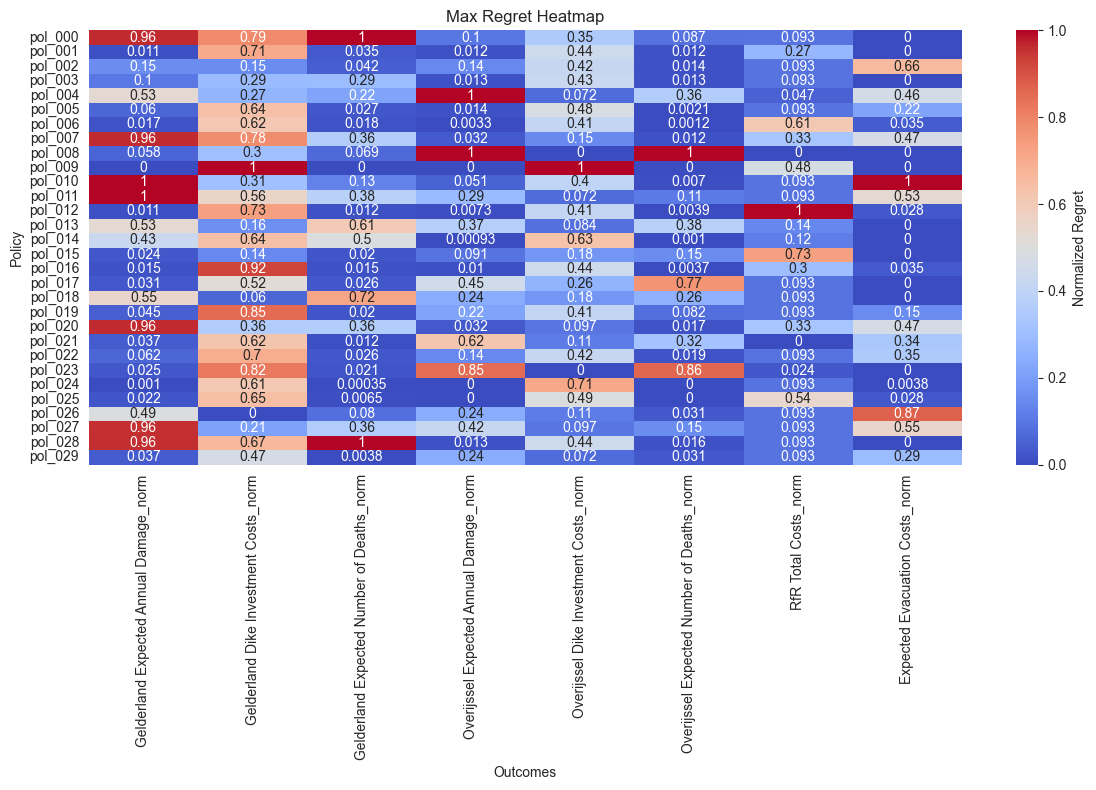

In [ ]:
plt.figure(figsize=(12, 8))
#sns.heatmap(df_max_regret.head(20)[max_norm_cols], annot=True, cmap='coolwarm', cbar_kws={'label': 'Normalized Regret'})
#plt.title("Max Regret Heatmap (Top 20 Policies)")


sns.heatmap(max_regret[max_norm_cols], annot=True, cmap='coolwarm', cbar_kws={'label': 'Normalized Regret'})
plt.title("Max Regret Heatmap")

plt.xlabel("Outcomes") 
plt.ylabel("Policy")
#plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

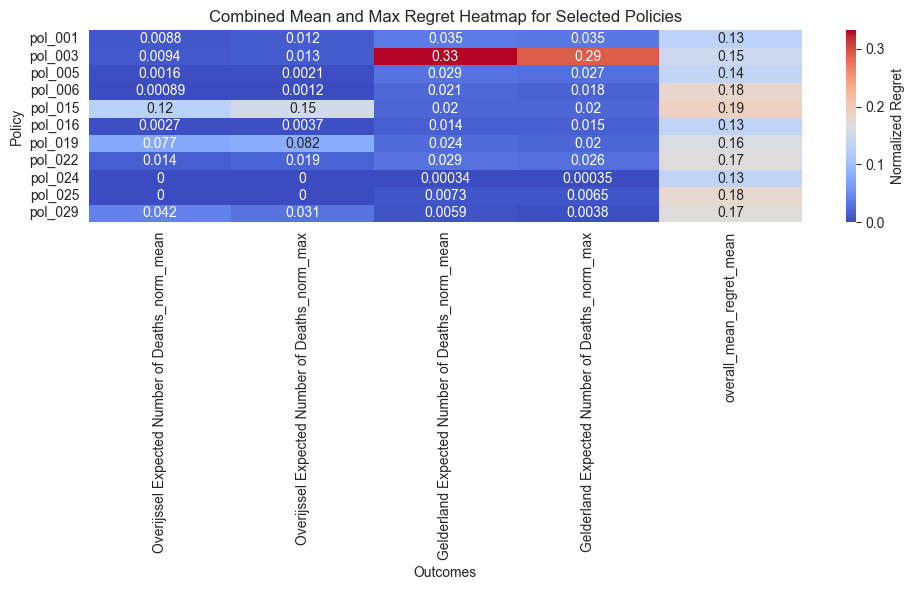

In [82]:
# Plot the mean and max regret next to each other in one heatmap, of a certain set of policies of 'Overijssel Expected Number of Deaths_norm' and 'Gelderland Expected Number of Deaths_norm'

# Define the policies of interest and extract the relevant columns
policies_of_interest = ['pol_001', 'pol_003', 'pol_005', 'pol_006', 'pol_015', 'pol_016', 'pol_019', 'pol_022', 'pol_024', 'pol_025', 'pol_029']
mean_regret_interest = mean_regret.loc[policies_of_interest, ['Overijssel Expected Number of Deaths_norm', 'Gelderland Expected Number of Deaths_norm', 'overall_mean_regret']]
max_regret_interest = max_regret.loc[policies_of_interest, ['Overijssel Expected Number of Deaths_norm', 'Gelderland Expected Number of Deaths_norm']]
# Combine mean and max regret into one DataFrame for plotting
combined_regret = pd.concat([mean_regret_interest.add_suffix('_mean'), max_regret_interest.add_suffix('_max')], axis=1)
# Set the column so that the two Overijssel and Gelderland columns are next to each other
combined_regret = combined_regret.reindex(columns=[
    'Overijssel Expected Number of Deaths_norm_mean', 
    'Overijssel Expected Number of Deaths_norm_max',
    'Gelderland Expected Number of Deaths_norm_mean',
    'Gelderland Expected Number of Deaths_norm_max',
    'overall_mean_regret_mean'])
# Plot the combined heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(combined_regret, annot=True, cmap='coolwarm', cbar_kws={'label': 'Normalized Regret'})
plt.title("Combined Mean and Max Regret Heatmap for Selected Policies")
plt.xlabel("Outcomes") 
plt.ylabel("Policy") 
plt.tight_layout()
plt.show()  

StopIteration: 

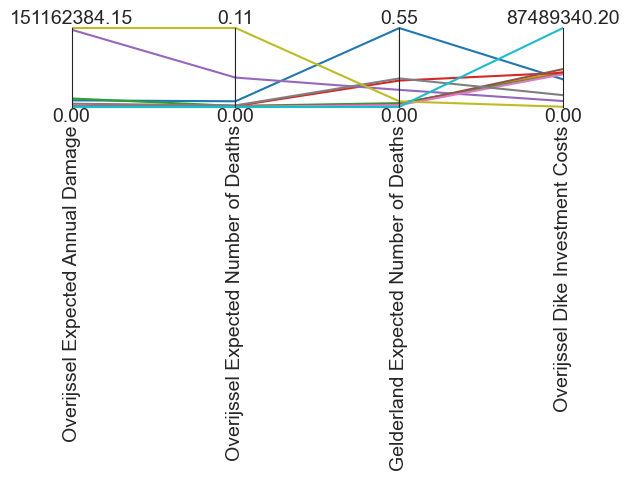

In [60]:
# Select only the relevant columns for the parallel coordinates plot
selected_cols = [
    "Overijssel Expected Annual Damage",
    "Overijssel Expected Number of Deaths",
    "Gelderland Expected Number of Deaths",
    "Overijssel Dike Investment Costs",
]

#mean_regret_top20_selected = df_mean_regret.head(20)[selected_cols]
mean_regret_selected = mean_regret[selected_cols]

# Get limits for the selected columns
limits_selected = parcoords.get_limits(mean_regret_selected)

# Create parallel axes for the selected outcomes
paraxes_selected = parcoords.ParallelAxes(limits_selected)

# Plot all rows in the selected mean regret DataFrame as parallel coordinates
colors = iter(sns.color_palette())
for i, row in mean_regret_selected.iterrows():
    color = next(colors)
    paraxes_selected.plot(row, label=f'Policy {i}', color=color)

paraxes_selected.legend()
plt.title("Parallel Coordinates Plot\nSelected Outcomes Only")
plt.xlabel("Outcomes")
plt.ylabel("Mean Regret")
plt.show()

StopIteration: 

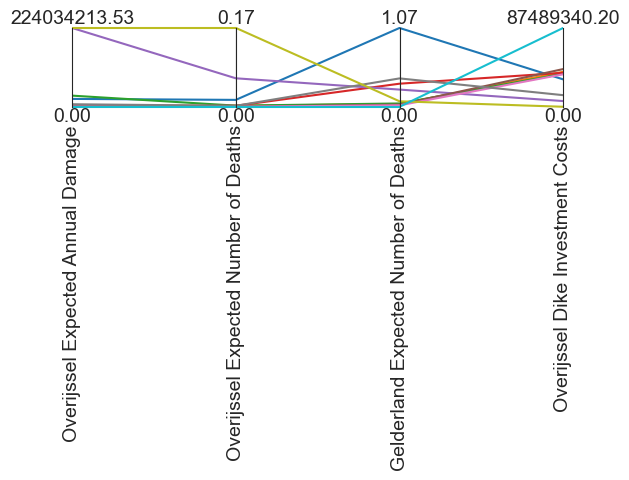

In [41]:
# Same for max regret

# Select only the relevant columns for the parallel coordinates plot
selected_cols = [
    "Overijssel Expected Annual Damage",
    "Overijssel Expected Number of Deaths",
    "Gelderland Expected Number of Deaths",
    "Overijssel Dike Investment Costs",
]

#max_regret_top20_selected = df_max_regret.head(20)[selected_cols]
max_regret_selected = max_regret[selected_cols]

# Get limits for the selected columns
limits_selected = parcoords.get_limits(max_regret_selected)

# Create parallel axes for the selected outcomes
paraxes_selected = parcoords.ParallelAxes(limits_selected)

# Plot all rows in the selected mean regret DataFrame as parallel coordinates
colors = iter(sns.color_palette())
for i, row in max_regret_selected.iterrows():
    color = next(colors)
    paraxes_selected.plot(row, label=f'Policy {i}', color=color)

paraxes_selected.legend()
plt.title("Parallel Coordinates Plot\nSelected Outcomes Only")
plt.xlabel("Outcomes")
plt.ylabel("Max Regret")
plt.show()

Old stuff